In [145]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.transform.msdlm as transform_msdlm

import pathlib

from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12, 9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [350]:
def read_msd_lm_df(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    return df_msd_lm.loc[df_msd_lm["t/LJ"] >= 1].copy()

def with_msdlm_bin_avg(df_msdlm: pd.DataFrame, bin_size: int = 100):
    bins = np.linspace(df_msdlm.index.min(), df_msdlm.index.max(), num=df_msdlm.shape[0] // bin_size)
    binned_idx = pd.cut(df_msdlm.index, bins)
    binned_msdlm_avg = df_msdlm.groupby(binned_idx).agg({
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": lambda ts: ts.min() + (ts.max() - ts.min())/2
    })
    return binned_msdlm_avg.set_index("t/LJ")

def with_savgol(df_msdlm: pd.DataFrame, window_size: int, polyorder: int):
    df_msdlm["dr_N^2"] = savgol_filter(x=df_msdlm["dr_N^2"], window_length=window_size, polyorder=polyorder)
    return df_msdlm

def with_msdlm_ma(df_msdlm: pd.DataFrame, window_size: int = 10, window_type="hamming"):
    df_msdlm["dr_N^2"] = df_msdlm["dr_N^2"].rolling(window_size, min_periods=1, win_type=window_type).mean()
    return df_msdlm.dropna()

def get_ete_mean(path):
    df_ete = pd.read_csv(path)

    def calc_mean_R(df):
        R = 0
        for dim in ["x", "y", "z"]:
            R += (df[f"R_{dim}"] ** 2).mean()
        return R

    return df_ete.groupby("t").apply(calc_mean_R).rename("R^2")

def smooth(x,window_len=11,window='hanning'):
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [502]:
N = 63
zeta = 1
b = .97
L_contour = N * b

experiments = [
    {
        "n": 17,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 6.02,
        "label": "EEA1-chain, $l_K/L=6.02$ "
    },
    {
        "n": 18,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76"),
        "zeta_e": 10.0,
        "l_K": 6.02,
        "label": "EEA1+Rab5-chain, $l_K/L=6.02$, $\\zeta_e=10.0$"
    },
    {
        "n": 19,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 0.6,
        "label": "EEA1-chain, $l_K/L=0.6$ (bonded-like)"
    },
    {
        "n": 20,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-full_flex/20-full_flex-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 1 / N,
        "label": "Fully flexible chain"
    },
]

for experiment in experiments:
    print(f"Reading {experiment['path']}...")
    experiment["df_msdlm raw"] = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd_avg.csv")
    df_unavg = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd.csv")
    experiment["df_msdlm raw"] = pd.concat([
        experiment["df_msdlm raw"], 
        df_unavg.loc[(df_unavg["t/LJ"] >= 1) & ((df_unavg["t/LJ"] <= 1000)) ]
    ]).sort_values(by="t/LJ").reset_index(drop=True)

Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-full_flex/20-full_flex-free_chain/ef6e4e76...


In [503]:
experiments[0]["df_msdlm raw"]

,t,kappa,dr_N^2,delta dr_N^2,t/LJ
0,35000400,190.2,0.649540,0.073495,1.000000e+00
1,35000401,190.2,0.651510,0.073696,1.002500e+00
2,35000402,190.2,0.653493,0.073901,1.005000e+00
3,35000403,190.2,0.655494,0.074109,1.007500e+00
4,35000404,190.2,0.657499,0.074318,1.010000e+00
...,...,...,...,...,...
83676,800000000,190.2,177912.881250,20707.412589,2.000000e+06
83677,800010000,190.2,177925.539062,20691.589194,2.000025e+06
83678,800020000,190.2,177889.307292,20677.692031,2.000050e+06
83679,800030000,190.2,177912.812500,20679.761792,2.000075e+06


In [504]:
bin_size = 3
window_size = 10

for experiment in experiments:
    df = experiment["df_msdlm raw"].copy()
    #print("Smoothing ...")
    #with_msdlm_ma(df, window_size=window_size, window_type="exponential")
    #print("Savgol ...")
    #with_savgol(df_msdlm=experiment["df_msdlm"], window_size=10, polyorder=1)
    #print(f"Binavg {experiment['path']}...")
    #df = with_msdlm_bin_avg(df, bin_size=bin_size)
    df.reset_index(inplace=True)
    experiment["df_msdlm"] = df
    # print(f"Reading ete")
    #experiment["df_ete_mean"] = get_ete_mean(experiment["path"] / "data" / "processed" / "ete.csv")

In [505]:
def get_rouse_msdlm_df(ts):
    tau_R = 1 / (3 * np.pi ** 2) * N ** 2 * b ** 2 * zeta
    R = N * b ** 2
    msdlm = rouse.rouse_msdlm(ts, R_sq=R, tau_R=tau_R, N=N)
    df_theor = pd.DataFrame({
        "t/LJ": ts,
        "dr_N^2": msdlm
    })
    return df_theor


df_rouse_msdlm = get_rouse_msdlm_df(experiments[0]["df_msdlm"]["t/LJ"])
df_rouse_msdlm

,t/LJ,dr_N^2
0,1.000000e+00,1.751209
1,1.002500e+00,1.753697
2,1.005000e+00,1.756181
3,1.007500e+00,1.758662
4,1.010000e+00,1.761141
...,...,...
83676,2.000000e+06,190495.757189
83677,2.000025e+06,190498.138141
83678,2.000050e+06,190500.519094
83679,2.000075e+06,190502.900046


Plotting 17 ...
Plotting 18 ...
Plotting 19 ...
Plotting 20 ...
Plotting 17 ...
Plotting 18 ...
Plotting 19 ...
Plotting 20 ...


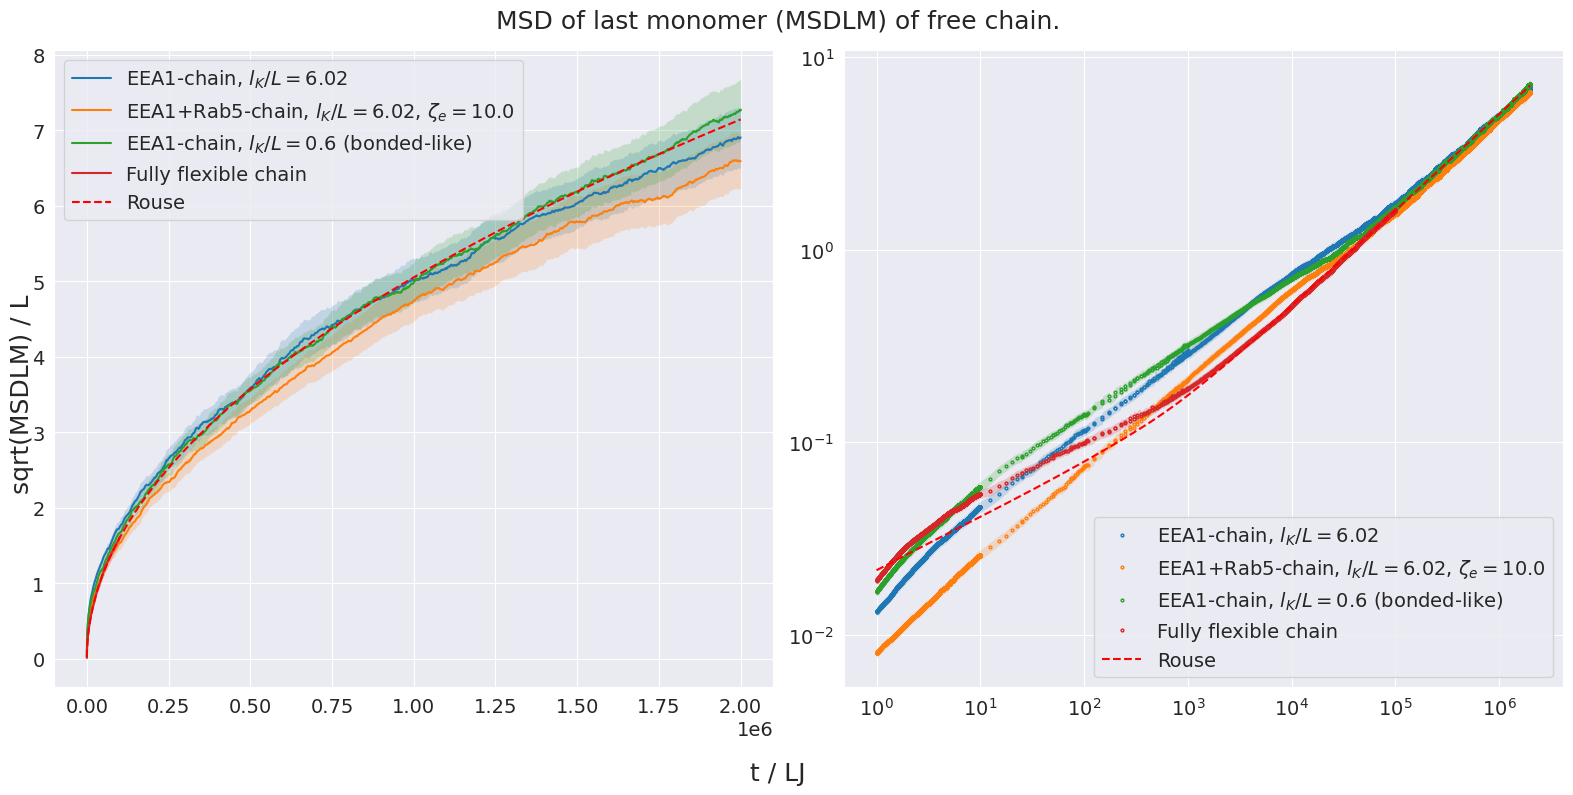

In [506]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, log in zip(axs, [False, True]):

    for experiment, color in zip(experiments, sns.color_palette()):
        
        print(f"Plotting {experiment['n']} ...")
        
        msd_plot.plot_MSD(
            experiment["df_msdlm"],
            log_scale=log,
            l_K=experiment["l_K"],
            L_contour=L_contour,
            zeta=zeta,
            zeta_e=experiment["zeta_e"],
            col="dr_N^2",
            label=experiment["label"],
            ax=ax,
            title="",
            ylabel="",
            xlabel="",
            scatter=log,
            marker_size=2,
            color=color
        )

    ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--", color="red")
    
    loc = "upper left" if not log else "lower right" 
    
    ax.legend(loc=loc)

fig.suptitle("MSD of last monomer (MSDLM) of free chain.")
fig.supylabel("sqrt(MSDLM) / L")
fig.supxlabel("t / LJ")
fig.tight_layout()

In [514]:
n_bins = 13
# bins=[0, 500, 3e3, 6e3, 1e4, 2e4, 4e4, 6e4, 1e5, 1e6]
for experiment in experiments:
    experiment["alpha"] = transform_msdlm.calculate_msd_alpha_df(experiment["df_msdlm"], n_bins=n_bins, )

alpha_rouse = transform_msdlm.calculate_msd_alpha_df(df_rouse_msdlm, n_bins)

experiments[0]["alpha"]

,alpha,delta alpha,delta t,interval,count
t/LJ,,,,,
1.0000,1.223640,0.005345,1.17500,"(1.0, 3.3500000000058208)",941
3.3525,0.961199,0.003494,3.32375,"(3.352500000008149, 10.0)",2660
12.5000,0.814665,0.048259,12.50000,"(12.5, 37.5)",12
40.0000,0.762558,0.030800,42.50000,"(40.0, 125.0)",34
150.0000,0.840892,0.040247,125.00000,"(150.0, 400.0)",22
425.0000,0.837526,0.021175,487.50000,"(425.0, 1400.0)",64
1425.0000,0.878180,0.012088,1650.00000,"(1425.0, 4725.0)",133
4750.0000,0.744176,0.006122,5550.00000,"(4750.0, 15850.0)",445
15875.0000,0.736301,0.003353,18650.00000,"(15875.0, 53175.0)",1493


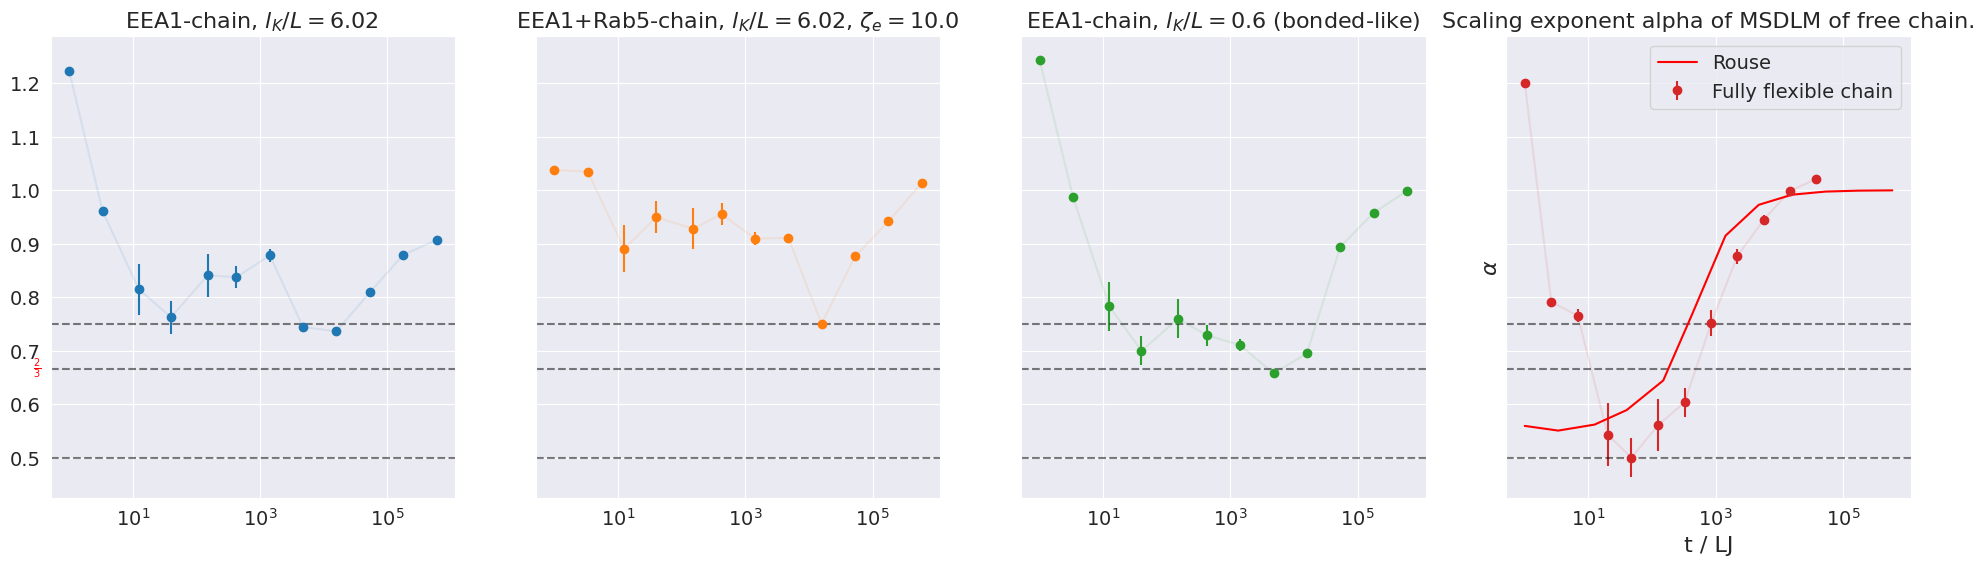

In [515]:
ax: plt.Axes
fig, axs = plt.subplots(ncols=4, figsize=(24, 6), sharey=True)

for color, experiment, ax in zip(sns.color_palette(), experiments, axs):
    ax.errorbar(
        experiment["alpha"].index, 
        y=experiment["alpha"]["alpha"], 
        yerr=experiment["alpha"]["delta alpha"],
        label=experiment["label"], 
        color=color,
        marker = "o",
        linestyle="none",
    )
    ax.plot(experiment["alpha"].index, experiment["alpha"]["alpha"], color=color, alpha=0.1)
    ax.set(xscale="log", title=experiment["label"])
    
    ax.axhline(y=2 / 3, color="black", linestyle="--", alpha=0.5)
    ax.axhline(y=3 / 4, color="black", linestyle="--", alpha=0.5)
    ax.axhline(y=1 / 2, color="black", linestyle="--", alpha=0.5)

axs[-1].plot(alpha_rouse.index, alpha_rouse["alpha"], linestyle="-", label="Rouse", color="red")


import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(
    axs[0].get_yticklabels()[0].get_transform(), 
    axs[0].transData
)

axs[0].text(
    0, 
    2/3, 
    "$\\frac{2}{3}$", 
    color="red", 
    transform=trans, 
    ha="right", 
    va="center"
)



ax.set(xscale="log", xlabel="t / LJ", ylabel="$\\alpha$", title="Scaling exponent alpha of MSDLM of free chain.")
ax.legend()